# **Birds 525 Species Image Classification**

This dataset contains 525 birds image, with 84,635 training images and 2625 test images and 2625 validation images (5 Images per species). You can download the dataset from [Kaggle](https://www.kaggle.com/datasets/gpiosenka/100-bird-species).
In this notebook, I will use Neural Networks to classify the images using Keras.  The dataset must be downloaded and extracted to the same directory as this notebook in a folder named `birds`.

Neccesary Libraries:

In [42]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import load_img

from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pickle

# **Exploratory Data Analysis (EDA) and Splitting the Data**

Load the dataset and explore the data.

In [19]:
base_path = 'birds/'

# Loading the data
birds_df = pd.read_csv(base_path + 'birds.csv')

# Updating the filepaths
birds_df['filepaths'] = base_path + birds_df['filepaths']

The dataset has a error in the csv file, the specie Paraket Auklet is referenced as Parakeet Akulet in the path of the images. I will modify the folder name to match the csv file.

In [20]:
import os
# Renaming the folder

if not os.path.exists(base_path + 'train/PARAKETT  AKULET'):
    os.rename(base_path + 'train/PARAKETT  AUKLET', base_path + 'train/PARAKETT  AKULET')

if not os.path.exists(base_path + 'test/PARAKETT  AKULET'):
    os.rename(base_path + 'test/PARAKETT  AUKLET', base_path + 'test/PARAKETT  AKULET')

if not os.path.exists(base_path + 'valid/PARAKETT  AKULET'):
    os.rename(base_path + 'valid/PARAKETT AUKLET', base_path + 'valid/PARAKETT  AKULET')


For the purpose of this notebook, I will use only 100 species of birds.

In [21]:
num_classes = 200

most_represented_birds = birds_df['labels'].value_counts().index[:num_classes]

birds_df = birds_df[birds_df['labels'].isin(most_represented_birds)]


class_mapping = {label: idx for idx, label in enumerate(most_represented_birds)}

birds_df['class id'] = birds_df['labels'].map(class_mapping)


Columns:

In [22]:
birds_df.columns

Index(['class id', 'filepaths', 'labels', 'data set', 'scientific name'], dtype='object')

Number of images in the dataset:

In [23]:
birds_df.shape

(38294, 5)

Number of images in the for each species:

In [24]:
birds_df['scientific name'].value_counts().head(5)

scientific name
PSITTACULA EUPATRIA       364
DENDROCITTA VAGABUNDA     273
HAEMORHOUS MEXICANUS      258
TRACHYPHONUS DARNAUDII    243
SEIURUS AUROCAPILLA       243
Name: count, dtype: int64

Get class names and its corresponding number representation:

In [25]:
# Get class names and its corresponding number representation:

classes = birds_df.groupby('class id')['scientific name'].unique()

Split the data into training, validation and test sets:

In [26]:
import random


r_classes = random.choices(classes.index, k=4)
r_classes


[38, 42, 59, 75]

Image example:

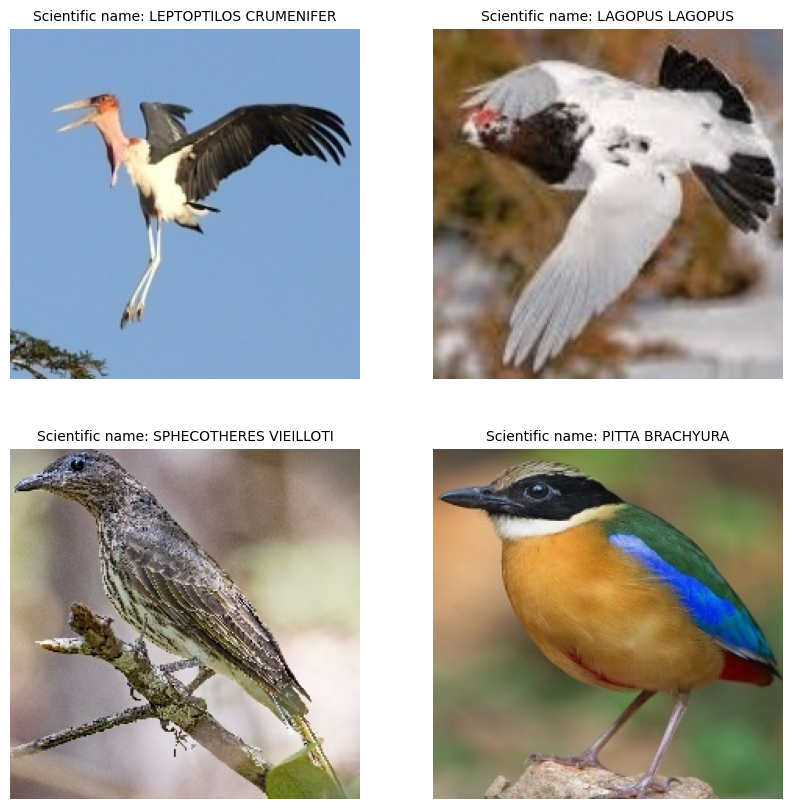

In [27]:

index = 0
plt.figure(figsize=(10, 10))
for c in r_classes:
    row = birds_df[birds_df['class id'] == c].sample(1).iloc[0]
    ax = plt.subplot(2, 2, index + 1)
    img = mpimg.imread(row['filepaths'])
    ax.imshow(img)
    ax.axis('off')

    ax.set_title(f"Scientific name: {row['scientific name']}", fontsize=10)
    index += 1




In [28]:
train_df = birds_df[birds_df['data set'] == 'train']
val_df = birds_df[birds_df['data set'] == 'valid']
test_df = birds_df[birds_df['data set'] == 'test']


In [29]:
train_df.shape, val_df.shape, test_df.shape

((36294, 5), (1000, 5), (1000, 5))

In [30]:
train_df['class id'].value_counts().head(5)

class id
0    263
1    248
3    233
2    233
4    220
Name: count, dtype: int64

# **Building the Model**

### *Data Preprocessing*

In [65]:
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [31]:
# Load and preprocess the images of df
def load_and_preprocess_images(df):
    data = []
    labels = []

    for index, row in df.iterrows():

        img = load_img(row['filepaths'], target_size=(64, 64))

        img_array = img_to_array(img)

        data.append(img_array)
        labels.append(row['class id'])

    return np.array(data), np.array(labels)


X_train, y_train = load_and_preprocess_images(train_df)
X_val, y_val = load_and_preprocess_images(val_df)
X_test, y_test = load_and_preprocess_images(test_df)


Example of the images after resizing:

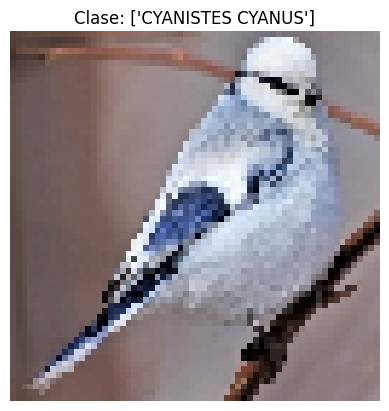

Clase: ['CYANISTES CYANUS']


In [32]:
index = 100

imagen = X_val[index].astype(int) 

# Mostrar la imagen
plt.imshow(imagen)
plt.title(f"Clase: {classes[y_val[index]]}")
plt.axis('off')  
plt.show()
print(f"Clase: {classes[y_val[index]]}")

In [33]:
# Normalize the images
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [46]:
from keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator




input_shape = X_val[0].shape

def create_baseline_model(num_classes=200):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


v1_model_path = 'models/birds_classification_v1.pkl'
v1_history_path = 'models/birds_classification_v1_history.pkl'

if os.path.exists(v1_model_path):
    print('Loading model...')
    model = pickle.load(open(v1_model_path, 'rb'))
    history = pickle.load(open(v1_history_path, 'rb'))

else:
    model = create_baseline_model(num_classes=num_classes)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)
    pickle.dump(model, open(v1_model_path, 'wb'))
    pickle.dump(history, open(v1_history_path, 'wb'))



Loading model...


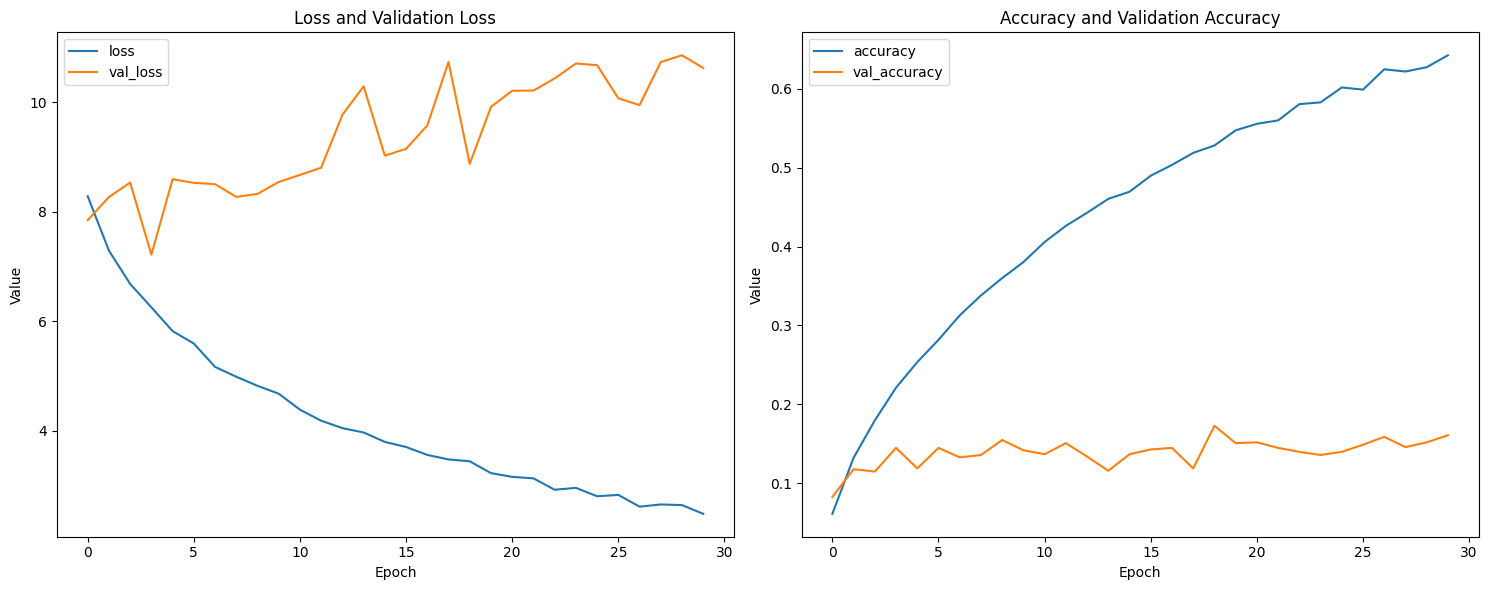

In [47]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss and val_loss on the first subplot
ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.set_title('Loss and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Value')
ax1.legend()

# Plot accuracy and val_accuracy on the second subplot
ax2.plot(history.history['accuracy'], label='accuracy')
ax2.plot(history.history['val_accuracy'], label='val_accuracy')
ax2.set_title('Accuracy and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Value')
ax2.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


Accuracy of the model in the training and validation sets:

In [48]:
scores = model.evaluate(X_train, y_train)
print("Train Accuracy: %.2f%%" % (scores[1]*100))

scores = model.evaluate(X_val, y_val)
print("Val Accuracy: %.2f%%" % (scores[1]*100))

scores = model.evaluate(X_test, y_test)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

1135/1135 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6046 - loss: 2.5987
Train Accuracy: 63.85%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1515 - loss: 10.7863 
Val Accuracy: 16.10%
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1718 - loss: 10.3590
Test Accuracy: 17.90%


Testin the model with image from internet:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


array(['PSITTACULA EUPATRIA'], dtype=object)

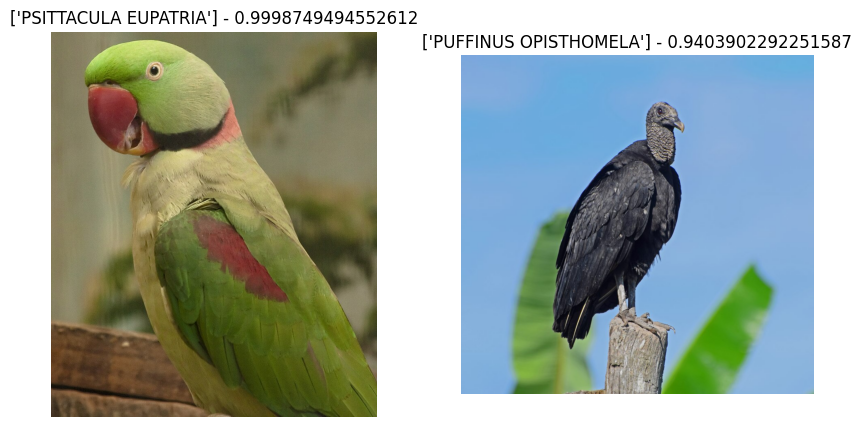

In [77]:
TEST_1 = 'birds/test_1.jpg'
TEST_2 = 'birds/test_2.jpg'


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

img_1 = preprocess_image(TEST_1, target_size=(64, 64))

ax1.imshow(mpimg.imread(TEST_1))
ax1.axis('off')

pred_1 = model.predict(img_1)
ax1.set_title(f"{classes[np.argmax(pred_1)]} - {np.max(pred_1)}")


img_2 = preprocess_image(TEST_2, target_size=(64, 64))

ax2.imshow(mpimg.imread(TEST_2))
ax2.axis('off')

pred_2 = model.predict(img_2)
ax2.set_title(f"{classes[np.argmax(pred_2)]} - {np.max(pred_2)}")


prediction = model.predict(img)


# Get the class with the highest probability
classes[np.argmax(prediction)]

### *Data Augmentation*